In [ ]:
'''
 * Copyright (c) 2005 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Levenberg-Marquardt Algorithm

The **Levenberg-Marquardt algorithm** is a variation of Newton's method designed for minimizing functions that are sums of squares of other nonlinear functions. This algorithm is particularly well-suited for training neural networks, where the performance index is typically the mean squared error.

### Basic Algorithm

Let's consider the form of Newton's method for optimizing a performance index $ F(x) $:

$$
x_{k+1} = x_k - A_k g_k,
$$

where:
- $ A_k \equiv \nabla^2 F(x) $ (the Hessian),
- $ g_k \equiv \nabla F(x) $ (the gradient).

If we assume that $ F(x) $ is a sum of squares function:

$$
F(x) = \sum_{i=1}^{N} v_i(x)^2 = v(x)^T v(x),
$$

the $ j $-th element of the gradient can be expressed as:

$$
\left[\nabla F(x)\right]_j = 2 \sum_{i=1}^{N} v_i(x) \frac{\partial v_i(x)}{\partial x_j}.
$$

This allows us to write the gradient in matrix form:

$$
\nabla F(x) = 2 J(x) v(x),
$$

where $ J(x) $ is the **Jacobian matrix** defined as:

$$
J(x) = 
\begin{bmatrix}
\frac{\partial v_1(x)}{\partial x_1} & \cdots & \frac{\partial v_1(x)}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial v_N(x)}{\partial x_1} & \cdots & \frac{\partial v_N(x)}{\partial x_n}
\end{bmatrix}.
$$

### Hessian Matrix

The $ k, j $-th element of the Hessian matrix can be written as:

$$
\left[\nabla^2 F(x)\right]_{k,j} = 2 \sum_{i=1}^{N} \frac{\partial v_i(x)}{\partial x_k} \frac{\partial v_i(x)}{\partial x_j} + 2 v_i(x) \frac{\partial^2 v_i(x)}{\partial x_k \partial x_j}.
$$

If we assume that the second term is small, we can approximate the Hessian matrix as:

$$
\nabla^2 F(x) \approx 2 J(x)^T J(x).
$$

Substituting this into Newton's method gives us the **Gauss-Newton method**:

$$
x_{k+1} = x_k - \left[J(x_k)^T J(x_k)\right]^{-1} J(x_k) v(x_k).
$$

### Modification for Non-Invertibility

One problem with the Gauss-Newton method is that the matrix $ H = J^T J $ may not be invertible. To overcome this, we use a modification:

$$
G = H + \mu_k I,
$$

where $ \mu_k $ is a positive scalar and $ I $ is the identity matrix. This ensures that the matrix $ G $ is invertible. The eigenvalues of $ G $ can be expressed as:

$$
G z_i = (\lambda_i + \mu_k) z_i,
$$

where $ \lambda_i $ are the eigenvalues of $ H $. Thus, we can make $ G $ positive definite by choosing $ \mu_k $ sufficiently large.

This leads to the Levenberg-Marquardt update rule:

$$
x_{k+1} = x_k - \left[J(x_k)^T J(x_k) + \mu_k I\right]^{-1} J(x_k) v(x_k).
$$

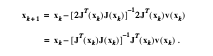








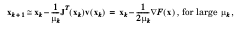


### Behavior of the Algorithm

- As $ \mu_k $ increases, the algorithm approaches the steepest descent method.
- As $ \mu_k $ decreases towards zero, the algorithm converges to the Gauss-Newton method.

The algorithm starts with a small $ \mu_k $ (e.g., $ \mu_k = 0.01 $). If a step does not reduce $ F(x) $, $ \mu_k $ is multiplied by a factor $ \gamma > 1 $ (e.g., $ \gamma = 10 $). If a step does reduce $ F(x) $, $ \mu_k $ is divided by $ \gamma $ for the next iteration.

### Application to Neural Network Training

The performance index for multilayer network training is typically the mean squared error, which can be expressed as:

$$
F(x) = \frac{1}{2} \sum_{q=1}^{Q} \left(t_q - a_q\right)^2,
$$

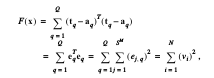

where:
- $ t_q $ is the target,
- $ a_q $ is the actual output.

This is equivalent to the performance index for which the Levenberg-Marquardt algorithm was designed, making it suitable for network training.


In [2]:
import random
import math

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize the network with random weights and biases
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights and biases
        self.weights_input_hidden = [[random.uniform(-0.1, 0.1) for _ in range(hidden_size)] for _ in range(input_size)]
        self.bias_hidden = [random.uniform(-0.1, 0.1) for _ in range(hidden_size)]
        self.weights_hidden_output = [[random.uniform(-0.1, 0.1) for _ in range(output_size)] for _ in range(hidden_size)]
        self.bias_output = [random.uniform(-0.1, 0.1) for _ in range(output_size)]
        
        # Store the final output and gradients
        self.final_output = [0] * output_size
        self.gradients_output = [0] * output_size
        self.gradients_hidden = [0] * hidden_size
        
        # Initialize other parameters
        self.mu = 0.01  # Damping factor
        self.gamma = 10  # Factor to increase mu
        self.epsilon = 1e-6  # Convergence threshold

    def sigmoid(self, x):
        # Use numpy's exp to avoid overflow errors
        if x < -709:  # This is the threshold for exp
            return 0.0
        elif x > 709:
            return 1.0
        return 1 / (1 + math.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, x):
        # Forward propagation
        self.hidden_layer_activation = [0] * self.hidden_size
        for j in range(self.hidden_size):
            self.hidden_layer_activation[j] = self.sigmoid(
                sum(x[i] * self.weights_input_hidden[i][j] for i in range(self.input_size)) + self.bias_hidden[j]
            )
        
        for k in range(self.output_size):
            self.final_output[k] = self.sigmoid(
                sum(self.hidden_layer_activation[j] * self.weights_hidden_output[j][k] for j in range(self.hidden_size)) + self.bias_output[k]
            )

    def compute_loss(self, y):
        # Mean Squared Error Loss
        return sum((y[i] - self.final_output[i]) ** 2 for i in range(self.output_size)) / 2

    def jacobian(self, x, y):
        # Compute Jacobian matrix J
        J = [[0] * self.output_size for _ in range(self.hidden_size)]
        for k in range(self.output_size):
            for j in range(self.hidden_size):
                J[j][k] = self.sigmoid_derivative(self.hidden_layer_activation[j]) * (y[k] - self.final_output[k])
        return J

    def update_weights(self, J, x, y):
        # Compute update using Levenberg-Marquardt
        H = [[0] * self.output_size for _ in range(self.output_size)]
        for k in range(self.output_size):
            for j in range(self.hidden_size):
                H[k][k] += J[j][k] * J[j][k]
        
        # Add damping factor
        for k in range(self.output_size):
            H[k][k] += self.mu

        # Compute gradient
        g = [0] * self.output_size
        for k in range(self.output_size):
            g[k] = sum(J[j][k] * (y[k] - self.final_output[k]) for j in range(self.hidden_size))

        # Update weights
        for k in range(self.output_size):
            for j in range(self.hidden_size):
                self.weights_hidden_output[j][k] -= (1 / H[k][k]) * g[k] * J[j][k]

        # Update biases
        for k in range(self.output_size):
            self.bias_output[k] -= self.mu * g[k]

    def train(self, X, Y, epochs):
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(X, Y):
                self.forward(x)
                total_loss += self.compute_loss(y)
                J = self.jacobian(x, y)
                self.update_weights(J, x, y)

            # Adjust mu based on the loss
            if total_loss < self.epsilon:
                self.mu /= self.gamma
            else:
                self.mu *= self.gamma

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss}')

# Example usage
if __name__ == "__main__":
    nn = NeuralNetwork(input_size=2, hidden_size=2, output_size=1)

    # Example training data (XOR problem)
    X = [[0, 0], [0, 1], [1, 0], [1, 1]]
    Y = [[0], [1], [1], [0]]

    nn.train(X, Y, epochs=1000)


Epoch 1/1000, Loss: 0.41520833857262374
Epoch 2/1000, Loss: 0.47169399792968575
Epoch 3/1000, Loss: 0.4991599769875995
Epoch 4/1000, Loss: 0.856407794104985
Epoch 5/1000, Loss: 0.9998800754406529
Epoch 6/1000, Loss: 1.0
Epoch 7/1000, Loss: 1.0
Epoch 8/1000, Loss: 1.0
Epoch 9/1000, Loss: 1.0
Epoch 10/1000, Loss: 1.0
Epoch 11/1000, Loss: 1.0
Epoch 12/1000, Loss: 1.0
Epoch 13/1000, Loss: 1.0
Epoch 14/1000, Loss: 1.0
Epoch 15/1000, Loss: 1.0
Epoch 16/1000, Loss: 1.0
Epoch 17/1000, Loss: 1.0
Epoch 18/1000, Loss: 1.0
Epoch 19/1000, Loss: 1.0
Epoch 20/1000, Loss: 1.0
Epoch 21/1000, Loss: 1.0
Epoch 22/1000, Loss: 1.0
Epoch 23/1000, Loss: 1.0
Epoch 24/1000, Loss: 1.0
Epoch 25/1000, Loss: 1.0
Epoch 26/1000, Loss: 1.0
Epoch 27/1000, Loss: 1.0
Epoch 28/1000, Loss: 1.0
Epoch 29/1000, Loss: 1.0
Epoch 30/1000, Loss: 1.0
Epoch 31/1000, Loss: 1.0
Epoch 32/1000, Loss: 1.0
Epoch 33/1000, Loss: 1.0
Epoch 34/1000, Loss: 1.0
Epoch 35/1000, Loss: 1.0
Epoch 36/1000, Loss: 1.0
Epoch 37/1000, Loss: 1.0
Epoch 38

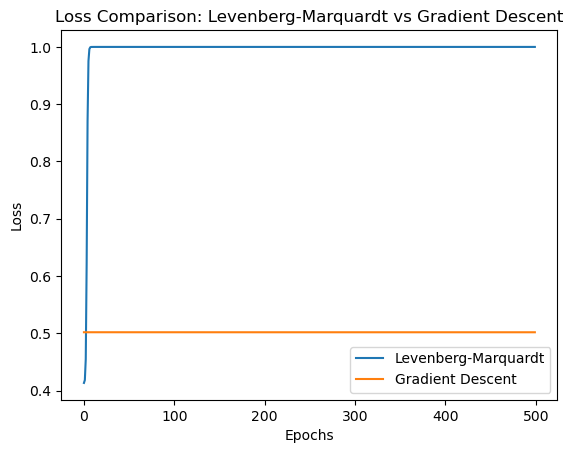

In [3]:
import random
import math
import matplotlib.pyplot as plt

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights and biases
        self.weights_input_hidden = [[random.uniform(-0.1, 0.1) for _ in range(hidden_size)] for _ in range(input_size)]
        self.bias_hidden = [random.uniform(-0.1, 0.1) for _ in range(hidden_size)]
        self.weights_hidden_output = [[random.uniform(-0.1, 0.1) for _ in range(output_size)] for _ in range(hidden_size)]
        self.bias_output = [random.uniform(-0.1, 0.1) for _ in range(output_size)]
        
        self.final_output = [0] * output_size
        self.mu = 0.01  # Damping factor for Levenberg-Marquardt
        self.gamma = 10  # Factor to increase mu
        self.epsilon = 1e-6  # Convergence threshold
    
    def sigmoid(self, x):
        if x < -709:
            return 0.0
        elif x > 709:
            return 1.0
        return 1 / (1 + math.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, x):
        self.hidden_layer_activation = [0] * self.hidden_size
        for j in range(self.hidden_size):
            self.hidden_layer_activation[j] = self.sigmoid(
                sum(x[i] * self.weights_input_hidden[i][j] for i in range(self.input_size)) + self.bias_hidden[j]
            )
        
        for k in range(self.output_size):
            self.final_output[k] = self.sigmoid(
                sum(self.hidden_layer_activation[j] * self.weights_hidden_output[j][k] for j in range(self.hidden_size)) + self.bias_output[k]
            )

    def compute_loss(self, y):
        return sum((y[i] - self.final_output[i]) ** 2 for i in range(self.output_size)) / 2

    # Levenberg-Marquardt Optimization
    def jacobian(self, x, y):
        J = [[0] * self.output_size for _ in range(self.hidden_size)]
        for k in range(self.output_size):
            for j in range(self.hidden_size):
                J[j][k] = self.sigmoid_derivative(self.hidden_layer_activation[j]) * (y[k] - self.final_output[k])
        return J

    def update_weights_lm(self, J, x, y):
        H = [[0] * self.output_size for _ in range(self.output_size)]
        for k in range(self.output_size):
            for j in range(self.hidden_size):
                H[k][k] += J[j][k] * J[j][k]
        
        for k in range(self.output_size):
            H[k][k] += self.mu

        g = [0] * self.output_size
        for k in range(self.output_size):
            g[k] = sum(J[j][k] * (y[k] - self.final_output[k]) for j in range(self.hidden_size))

        for k in range(self.output_size):
            for j in range(self.hidden_size):
                self.weights_hidden_output[j][k] -= (1 / H[k][k]) * g[k] * J[j][k]

        for k in range(self.output_size):
            self.bias_output[k] -= self.mu * g[k]

    # Gradient Descent Update
    def update_weights_gd(self, x, y, lr=0.01):
        output_errors = [y[i] - self.final_output[i] for i in range(self.output_size)]
        hidden_errors = [0] * self.hidden_size
        
        for j in range(self.hidden_size):
            hidden_errors[j] = sum(output_errors[k] * self.weights_hidden_output[j][k] for k in range(self.output_size)) * self.sigmoid_derivative(self.hidden_layer_activation[j])
        
        for k in range(self.output_size):
            for j in range(self.hidden_size):
                self.weights_hidden_output[j][k] += lr * output_errors[k] * self.hidden_layer_activation[j]
            self.bias_output[k] += lr * output_errors[k]
        
        for j in range(self.hidden_size):
            for i in range(self.input_size):
                self.weights_input_hidden[i][j] += lr * hidden_errors[j] * x[i]
            self.bias_hidden[j] += lr * hidden_errors[j]

    # Train function with selected optimizer
    def train(self, X, Y, epochs, optimizer="lm"):
        losses = []
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(X, Y):
                self.forward(x)
                total_loss += self.compute_loss(y)
                
                if optimizer == "lm":
                    J = self.jacobian(x, y)
                    self.update_weights_lm(J, x, y)
                elif optimizer == "gd":
                    self.update_weights_gd(x, y)

            losses.append(total_loss)
        return losses

# Plotting function to compare loss for different optimizers
def plot_comparison(X, Y, epochs):
    nn_lm = NeuralNetwork(input_size=2, hidden_size=2, output_size=1)
    nn_gd = NeuralNetwork(input_size=2, hidden_size=2, output_size=1)
    
    # Training with Levenberg-Marquardt
    lm_losses = nn_lm.train(X, Y, epochs, optimizer="lm")
    
    # Training with Gradient Descent
    gd_losses = nn_gd.train(X, Y, epochs, optimizer="gd")
    
    # Plotting the loss curves
    plt.plot(range(epochs), lm_losses, label="Levenberg-Marquardt")
    plt.plot(range(epochs), gd_losses, label="Gradient Descent")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Comparison: Levenberg-Marquardt vs Gradient Descent")
    plt.legend()
    plt.show()

# Example usage
if __name__ == "__main__":
    X = [[0, 0], [0, 1], [1, 0], [1, 1]]  # XOR dataset
    Y = [[0], [1], [1], [0]]
    plot_comparison(X, Y, epochs=500)


## Jacobian Matrix Calculation for Levenberg-Marquardt Algorithm

The key step in the Levenberg-Marquardt algorithm is the computation of the Jacobian matrix. To perform this computation, we will use a variation of the backpropagation algorithm. Recall that in the standard backpropagation procedure, we compute the derivatives of the squared errors with respect to the weights and biases of the network. 

To create the Jacobian matrix, we need to compute the derivatives of the errors instead of the derivatives of the squared errors. Conceptually, modifying the backpropagation algorithm to compute the elements of the Jacobian matrix is simple, but the implementation details can be tricky.

## Error Vector

The error vector is given by:

$$
v = \begin{bmatrix}
e_{1,1} & e_{2,1} & \cdots & e_{M,1} \\
e_{1,2} & e_{2,2} & \cdots & e_{M,2} \\
\vdots & \vdots & \ddots & \vdots \\
e_{1,Q} & e_{2,Q} & \cdots & e_{M,Q}
\end{bmatrix}
$$

Where:

- $ e_{i,j} $ is the error at node $ i $ for the $ j $-th data sample.

## Parameter Vector

The parameter vector, which includes weights and biases, is given by:

$$
x = \begin{bmatrix}
w_{11,1} & w_{11,2} & \cdots & w_{11,R} & b_{1,1} & \cdots & b_{M,M}
\end{bmatrix}
$$

The number of parameters $ n $ is:

$$
n = S \cdot (R + 1) + S_1 \cdot (S_2 + 1) + \cdots + S_M
$$

## Jacobian Matrix

Using these definitions, the Jacobian matrix for a multilayer network can be written as:

$$
J(x) = \begin{bmatrix}
\frac{\partial e_{1,1}}{\partial w_{1,1}} & \frac{\partial e_{1,1}}{\partial w_{1,2}} & \cdots & \frac{\partial e_{1,1}}{\partial b_{1}} \\
\frac{\partial e_{2,1}}{\partial w_{1,1}} & \frac{\partial e_{2,1}}{\partial w_{1,2}} & \cdots & \frac{\partial e_{2,1}}{\partial b_{1}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial e_{M,1}}{\partial w_{1,1}} & \frac{\partial e_{M,1}}{\partial w_{1,2}} & \cdots & \frac{\partial e_{M,1}}{\partial b_{1}} \\
\end{bmatrix}
$$

## Computation of Jacobian Matrix Elements

In standard backpropagation, we compute derivatives of the squared errors as:

$$
\frac{\partial \hat{F}(x)}{\partial x_l} = \frac{\partial e_q}{\partial x_l}
$$

For the Jacobian, we compute the derivatives of the errors directly:

$$
[J]_{h,l} = \frac{\partial v_h}{\partial x_l} = \frac{\partial e_{k,q}}{\partial x_l}
$$

Where $ v_h $ is the error at node $ h $.

### Backpropagation Recurrence Relation

From backpropagation, we know:

$$
\frac{\partial \hat{F}}{\partial w_{i,j}} = \frac{\partial \hat{F}}{\partial n_i^m} \cdot \frac{\partial n_i^m}{\partial w_{i,j}}
$$

Where $ \frac{\partial \hat{F}}{\partial n_i^m} $ is defined as the sensitivity $ s_i $. Using the same recurrence relationship as in standard backpropagation, we compute the Jacobian elements as:

$$
[J]_{h,l} = \frac{\partial v_h}{\partial x_l} = s_{i,h} \cdot a_{j,q}
$$

For biases:

$$
[J]_{h,l} = s_{i,h}
$$

The sensitivities can be computed using the recurrence relations from standard backpropagation with a modification at the final layer for the Levenberg-Marquardt sensitivities.


## Levenberg-Marquardt Backpropagation Algorithm (LMBP)

The calculation of Marquardt sensitivities $ \tilde{s}_{i,h} $ for the Jacobian matrix involves modifying the standard backpropagation algorithm.

We start by calculating:

$$
\tilde{s}_{i,h}^M = \frac{\partial v_h^M}{\partial n_i^M} = \frac{\partial e_{k,q}^M}{\partial n_i^M} = \frac{\partial (t_{k,q}^M - a_{k,q}^M)}{\partial n_i^M} = -\frac{\partial a_{k,q}^M}{\partial n_i^M}
$$

Thus,

$$
\tilde{s}_{i,h}^M = \begin{cases} 
- f'(n_i^M) & \text{for } i = k \\
0 & \text{for } i \neq k 
\end{cases}
$$

(Equation 12.45)

## Initialization

After the input $ p_q $ has been applied to the network and the corresponding network output $ a_q $ has been computed, the Levenberg-Marquardt backpropagation is initialized with:

$$
\tilde{S}_q^M = -F'(n_q^M)
$$

(Equation 12.46)

Here, $ F(n_q^M) $ is defined in Equation (11.34).

Each column of the matrix $ \tilde{S}_q^M $ must be backpropagated through the network using:

$$
\tilde{S}_q^M = F'(n_q^M) \left( W^m \right)^T \tilde{S}_q^{m+1}
$$

(Equation 12.47)

The total Marquardt sensitivity matrices for each layer are created by augmenting the matrices computed for each input:

$$
\tilde{S}^m = [\tilde{S}_1^m \ \tilde{S}_2^m \ \dots \ \tilde{S}_Q^m]
$$

(Equation 12.48)

For each input applied to the network, we will backpropagate $ S $ sensitivity vectors, because we compute the derivatives of each individual error instead of the sum of squares of the errors.

For every input, there will be $ S $ errors (one for each element of the network output), and for each error, there will be one row of the Jacobian matrix.

After backpropagating the sensitivities, the Jacobian matrix is computed using Equations (12.43) and (12.44).

### Levenberg-Marquardt Backpropagation Steps

1. **Present all inputs** to the network and compute the corresponding network outputs using Equations (11.41) and (11.42). Compute the errors:

$$
e_q = t_q - a_q
$$

Then, compute the sum of squared errors over all inputs, $ F(x) $, using Equation (12.34).

2. **Compute the Jacobian matrix** using Equation (12.37). Calculate the sensitivities with the recurrence relations in Equation (12.47), after initializing with Equation (12.46). Augment the individual matrices into the Marquardt sensitivities using Equation (12.48). Compute the elements of the Jacobian matrix with Equations (12.43) and (12.44).

3. **Solve** Equation (12.32) to obtain $ \Delta x_k $.

4. **Recompute the sum of squared errors** using $ x_k + \Delta x_k $. If the new sum of squares is smaller than the sum computed in Step 1, divide $ \mu $ by $ \nu $, let $ x_{k+1} = x_k + \Delta x_k $, and return to Step 1. If the sum of squares is not reduced, multiply $ \mu $ by $ \nu $ and return to Step 3.

The algorithm is assumed to have converged when the norm of the gradient (Equation 12.22) is less than a predetermined value or when the sum of squares has been reduced to a specific error goal.

### Illustration of LMBP

Let's apply the LMBP algorithm to the function approximation problem introduced earlier in the chapter. Figure.17 illustrates possible steps the LMBP algorithm could take in the first iteration.


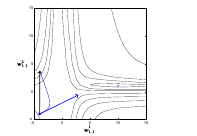

Figure.17 Levenberg-Marquardt Step

The black arrow represents the direction taken for small $ \mu_k $, which corresponds to the Gauss-Newton direction. The blue arrow represents the direction taken for large $ \mu_k $, corresponding to the steepest descent direction.

The blue curve represents the Levenberg-Marquardt step for all intermediate values of $ \mu_k $. Note that as $ \mu_k $ increases, the algorithm moves toward a small step in the steepest descent direction, ensuring that the algorithm always reduces the sum of squares at each iteration.




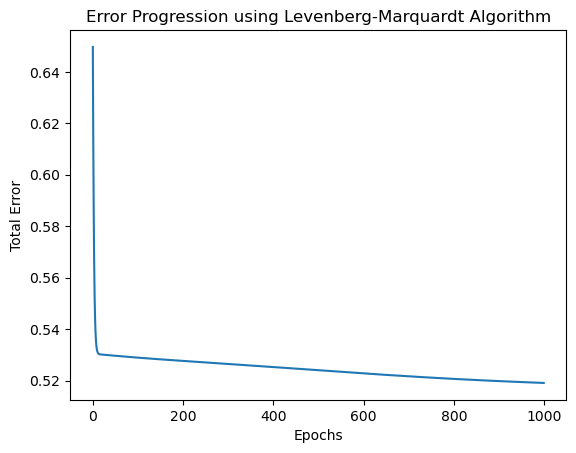

In [4]:
import math
import random
import matplotlib.pyplot as plt

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Derivative of sigmoid for backpropagation
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Levenberg-Marquardt Algorithm for training a simple network
class LevenbergMarquardtNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights and biases
        self.weights_input_hidden = [[random.random() for _ in range(hidden_size)] for _ in range(input_size)]
        self.weights_hidden_output = [[random.random() for _ in range(output_size)] for _ in range(hidden_size)]
        self.bias_hidden = [random.random() for _ in range(hidden_size)]
        self.bias_output = [random.random() for _ in range(output_size)]
    
    def forward(self, x):
        self.hidden_layer_activation = [0] * self.hidden_size
        self.output_layer_activation = [0] * self.output_size
        
        # Input to hidden layer
        for j in range(self.hidden_size):
            activation = sum(x[i] * self.weights_input_hidden[i][j] for i in range(self.input_size)) + self.bias_hidden[j]
            self.hidden_layer_activation[j] = sigmoid(activation)
        
        # Hidden to output layer
        for k in range(self.output_size):
            activation = sum(self.hidden_layer_activation[j] * self.weights_hidden_output[j][k] for j in range(self.hidden_size)) + self.bias_output[k]
            self.output_layer_activation[k] = sigmoid(activation)
        
        return self.output_layer_activation
    
    def compute_error(self, target):
        # Mean squared error
        return sum((target[i] - self.output_layer_activation[i]) ** 2 for i in range(self.output_size)) / 2
    
    def update_weights(self, x, target, learning_rate, mu):
        # Backpropagation and update weights using LMA
        delta_output = [0] * self.output_size
        delta_hidden = [0] * self.hidden_size
        
        # Calculate output layer delta
        for k in range(self.output_size):
            delta_output[k] = (target[k] - self.output_layer_activation[k]) * sigmoid_derivative(self.output_layer_activation[k])
        
        # Calculate hidden layer delta
        for j in range(self.hidden_size):
            delta_hidden[j] = sum(delta_output[k] * self.weights_hidden_output[j][k] for k in range(self.output_size)) * sigmoid_derivative(self.hidden_layer_activation[j])
        
        # Update weights from hidden to output
        for j in range(self.hidden_size):
            for k in range(self.output_size):
                self.weights_hidden_output[j][k] += learning_rate * delta_output[k] * self.hidden_layer_activation[j]
        
        # Update weights from input to hidden
        for i in range(self.input_size):
            for j in range(self.hidden_size):
                self.weights_input_hidden[i][j] += learning_rate * delta_hidden[j] * x[i]
        
        # Update biases
        for k in range(self.output_size):
            self.bias_output[k] += learning_rate * delta_output[k]
        
        for j in range(self.hidden_size):
            self.bias_hidden[j] += learning_rate * delta_hidden[j]

# Training data
input_data = [[0, 0], [0, 1], [1, 0], [1, 1]]
target_data = [[0], [1], [1], [0]]  # XOR problem

# Initialize network
lm_network = LevenbergMarquardtNetwork(input_size=2, hidden_size=2, output_size=1)

# Training parameters
epochs = 1000
learning_rate = 0.5
mu = 0.01
errors = []

# Training loop
for epoch in range(epochs):
    total_error = 0
    for i in range(len(input_data)):
        # Forward pass
        output = lm_network.forward(input_data[i])
        
        # Compute error
        total_error += lm_network.compute_error(target_data[i])
        
        # Update weights
        lm_network.update_weights(input_data[i], target_data[i], learning_rate, mu)
    
    errors.append(total_error)

# Plot the error over epochs
plt.plot(range(epochs), errors)
plt.xlabel('Epochs')
plt.ylabel('Total Error')
plt.title('Error Progression using Levenberg-Marquardt Algorithm')
plt.show()


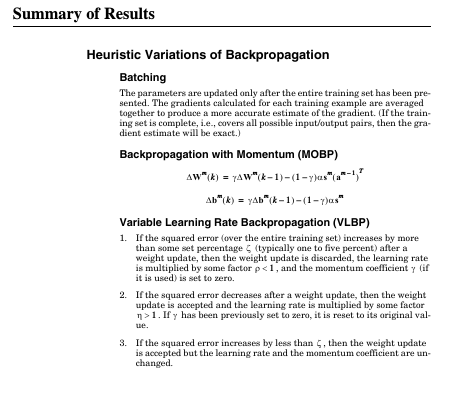

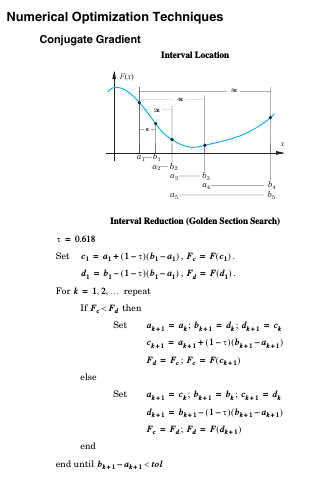

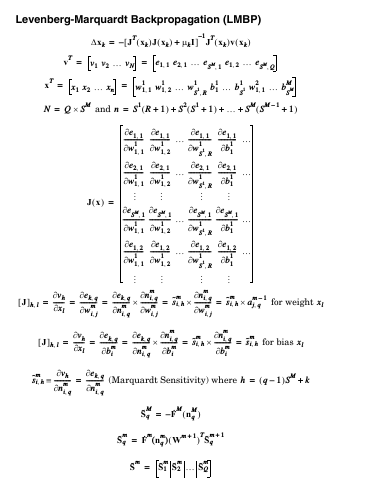

## Levenberg-Marquardt Iterations

### Step 1:
Present all inputs to the network and compute the corresponding network outputs using the following equations:

$$
a_q = f(x_q)
$$

where $ a_q $ is the network output for the $ q^{th} $ input.

Calculate the errors:

$$
e_q = t_q - a_q
$$

where $ t_q $ is the target output for input $ x_q $.

Compute the sum of squared errors over all inputs:

$$
F(x) = \frac{1}{2} \sum_{q=1}^{Q} e_q^2
$$

### Step 2:
Compute the Jacobian matrix $ J(x) $ using:

$$
J(x) = \frac{\partial e}{\partial x}
$$

To calculate the sensitivities, use the recurrence relation:

$$
\tilde{S}_q = -F'(n_q)
$$

where $ F'(n_q) $ is the derivative of the activation function.

Augment the individual matrices into the Marquardt sensitivities:

$$
\tilde{S} = [\tilde{S}_1 \, \tilde{S}_2 \, \dots \, \tilde{S}_Q]
$$

### Step 3:
Solve for $ \Delta x_k $ using:

$$
(J(x_k)^T J(x_k) + \mu I) \Delta x_k = -J(x_k)^T e_k
$$

### Step 4:
Recompute the sum of squared errors using the updated parameters:

$$
F(x_k + \Delta x_k)
$$

If the new sum of squared errors is smaller than the previous one, reduce $ \mu $ by a factor $ \theta $, update the parameters:

$$
x_{k+1} = x_k + \Delta x_k
$$

and return to Step 1. 

If the sum of squared errors does not reduce, increase $ \mu $ by a factor $ \theta $ and return to Step 3.
